# Alice's Workspace for Final Project

In [1]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
!pwd

/media/notebooks/w261_final_project/misc_code


In [ ]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.0.jar"
HDFS_DIR = "/user/root/final_project"
#!pwd
HOME_DIR = "/media/notebooks/w261_final_project/misc_code" 

In [ ]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [ ]:
# data path
ENRON = "data/enronemail_1h.txt"

#### Setup Spark Session

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "FinalProject_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

#### Load data

In [141]:
# create dataframe from train_0005.tsv
df = spark.read.csv('../data/train_005.tsv', sep='\t')

## EDA

#### 1. Take a first look at the data

In [142]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

##### All of them are in string. We know some columns are numerical variables. We need to fix that later

In [145]:
traindf.head(3)

[Row(_c0='0', _c1=None, _c2='-1', _c3=None, _c4=None, _c5=None, _c6=None, _c7=None, _c8=None, _c9=None, _c10=None, _c11=None, _c12=None, _c13=None, _c14='05db9164', _c15='38a947a1', _c16='4093220a', _c17='6a14f9b9', _c18='43b19349', _c19='7e0ccccf', _c20='3ffb655b', _c21='1f89b562', _c22='7cc72ec2', _c23='3b08e48b', _c24='d3246de4', _c25='002ec9ad', _c26='31078fbf', _c27='07d13a8f', _c28='586a2aab', _c29='f8b34416', _c30='2005abd1', _c31='e5f8f18f', _c32=None, _c33=None, _c34='f3ddd519', _c35=None, _c36='be7c41b4', _c37='b34f3128', _c38=None, _c39=None),
 Row(_c0='0', _c1=None, _c2='-1', _c3=None, _c4=None, _c5=None, _c6=None, _c7=None, _c8=None, _c9=None, _c10=None, _c11=None, _c12=None, _c13=None, _c14='05db9164', _c15='38a947a1', _c16='c94dc713', _c17='7686d73f', _c18='25c83c98', _c19='fbad5c96', _c20='bcf6609d', _c21='0b153874', _c22='7cc72ec2', _c23='3b08e48b', _c24='bf47c6ee', _c25='c0c9a369', _c26='208257bb', _c27='07d13a8f', _c28='6d4ff9ff', _c29='3759ec50', _c30='2005abd1', _c

##### There is no column names and the values are all converted to bitwise info.

In [216]:
traindf.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------+--------+--------+--------+--------------------+--------+--------+--------------------+--------+--------+--------+--------+--------+--------------------+--------+--------+---------+--------+--------+--------+--------+--------+-----------+--------+---------+--------+
|summary|                _c0|               _c1|               _c2|               _c3|              _c4|              _c5|               _c6|              _c7|               _c8|               _c9|              _c10|             _c11|              _c12|              _c13|    _c14|    _c15|    _c16|    _c17|                _c18|    _c19|    _c20|                _c21|    _c22|    _c23|    _c24|    _c25|    _c26|                _c27|    _c28|    _c29|

__Based on the description from the competition and also the description above, we know that column 0-13 are integer values, column 14-39 are categorical values. There is no column that has zero valid data.__

In [148]:
from pyspark.sql.types import *
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

In [178]:
numerical_col = ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13']

In [179]:
df = convertColumn(df, numerical_col, FloatType())

In [150]:
df.printSchema()

root
 |-- _c0: float (nullable = true)
 |-- _c1: float (nullable = true)
 |-- _c2: float (nullable = true)
 |-- _c3: float (nullable = true)
 |-- _c4: float (nullable = true)
 |-- _c5: float (nullable = true)
 |-- _c6: float (nullable = true)
 |-- _c7: float (nullable = true)
 |-- _c8: float (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c10: float (nullable = true)
 |-- _c11: float (nullable = true)
 |-- _c12: float (nullable = true)
 |-- _c13: float (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = true)
 |-- _c28: 

### 2. Df is corrected ->  train/test split

In [151]:
splits = df.randomSplit([0.2, 0.8], seed=2615)
testdf = splits[0]
traindf = splits[1]

#### Label distribution

In [40]:
testdf.groupBy("_c0").count().show()

+---+-----+
|_c0|count|
+---+-----+
|  0| 3455|
|  1| 1123|
+---+-----+



In [132]:
traindf.groupBy("_c0").count().show()

+---+-----+
|_c0|count|
+---+-----+
|  0|13602|
|  1| 4777|
+---+-----+



#### There's about 25% of label 1 and 75% of label 0 in both train/test set. We do not have a balanced dataset. However, the imbalance is also not as extreme as say fraud detection that may be just under 10% of the samples.

In [111]:
columns = traindf.columns[1:]
distinct_count = []
for col in columns:
    distinct_count.append(traindf.select(col).distinct().count())

In [116]:
for col, count in zip(columns, distinct_count):
    print (col, ":", count)

_c1 : 91
_c2 : 1188
_c3 : 317
_c4 : 68
_c5 : 8442
_c6 : 943
_c7 : 360
_c8 : 61
_c9 : 987
_c10 : 9
_c11 : 69
_c12 : 45
_c13 : 102
_c14 : 230
_c15 : 439
_c16 : 10305
_c17 : 6978
_c18 : 83
_c19 : 10
_c20 : 4497
_c21 : 129
_c22 : 3
_c23 : 4842
_c24 : 2683
_c25 : 9644
_c26 : 2184
_c27 : 25
_c28 : 2812
_c29 : 8588
_c30 : 9
_c31 : 1540
_c32 : 702
_c33 : 4
_c34 : 9202
_c35 : 10
_c36 : 14
_c37 : 4061
_c38 : 45
_c39 : 3117


In [220]:
traindf.select(numerical_col[0:7]).describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|summary|                _c0|               _c1|               _c2|               _c3|              _c4|              _c5|               _c6|
+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  count|              18379|             10109|             18379|             14386|            14314|            17905|             14191|
|   mean|0.25991620871646987|3.5502027895934316|101.80967408455302| 25.63763381064924| 7.30068464440408|18436.65942474169|111.70875907265167|
| stddev|0.43860031921230597| 9.293289659497264|374.02991892400274|331.46919953261744|8.624079890068804|68931.50353591116|332.34996893862655|
|    min|                0.0|               0.0|              -2.0|               0.0|              0.0|              0.0|               0.0|
|    m

In [221]:
traindf.select(numerical_col[7:]).describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|              _c7|               _c8|               _c9|              _c10|             _c11|              _c12|              _c13|
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|            17600|             18369|             17600|             10109|            17600|              4282|             14314|
|   mean|17.12034090909091|12.419293374707387|106.89028409090909|0.6220199821940845|2.790738636363636|0.8895375992526856| 8.168366634064553|
| stddev|66.91093732423182|14.088934412061754|227.30410625706682|0.6948805353765156|5.310155836571858|3.8061148775636693|11.428526114043635|
|    min|              0.0|               0.0|               0.0|               0.0|              0.0|               0.0|               0.0|
|    max|    

In [229]:
from pyspark.sql.functions import rand

#### Check NA

In [286]:
from pyspark.sql.functions import isnan, when, count, col, desc
traindf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindf.columns]).show()

+---+----+---+----+----+---+----+---+---+---+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+
|_c0| _c1|_c2| _c3| _c4|_c5| _c6|_c7|_c8|_c9|_c10|_c11| _c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34| _c35|_c36|_c37|_c38|_c39|
+---+----+---+----+----+---+----+---+---+---+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+
|  0|8270|  0|3993|4065|474|4188|779| 10|779|8270| 779|14097|4065|   0|   0| 653| 653|   0|2260|   0|   0|   0|   0|   0| 653|   0|   0|   0| 653|   0|   0|8082|8082| 653|13890|   0| 653|8082|8082|
+---+----+---+----+----+---+----+---+---+---+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+



In [ ]:
import spark.sql.functions

#### Reaplace null with median or most frequent variables

##### Just for seeing the values below

In [348]:
[x[0] for x in traindf.approxQuantile(traindf.columns[1:14], [0.5], 0)]

[1.0, 3.0, 6.0, 4.0, 2774.0, 32.0, 3.0, 7.0, 37.0, 1.0, 1.0, 0.0, 4.0]

In [344]:
traindf.groupBy(traindf.columns[14:]).count().sort(desc("count")).collect()[0]

Row(_c14='05db9164', _c15='95e2d337', _c16='95c48c52', _c17='30b862e7', _c18='25c83c98', _c19='7e0ccccf', _c20='a6950954', _c21='37e4aa92', _c22='a73ee510', _c23='3b08e48b', _c24='a2407991', _c25='f0d5cc59', _c26='decd9980', _c27='1adce6ef', _c28='559cd202', _c29='e9194f3c', _c30='e5ba7672', _c31='7b06fafe', _c32='85684dc0', _c33='a458ea53', _c34='cb105f80', _c35='ad3062eb', _c36='be7c41b4', _c37='16bb3de8', _c38='2bf691b1', _c39='d3b2f8c3', count=1)

##### The actual code

In [350]:
fillna_dict_num = {key: value for (key, value) in zip(traindf.columns[1:14], [x[0] for x in traindf.approxQuantile(traindf.columns[1:14],[0.5],0)])}
fillna_dict_cat = {key: value for (key, value) in zip(traindf.columns[14:], traindf.groupBy(traindf.columns[14:]).count().sort(desc("count")).collect()[0])}
traindf_nafilled = traindf.na.fill(fillna_dict_num).na.fill(fillna_dict_cat)
#traindf_nafilled = traindf.na.fill(fillna_dict_cat)  

In [232]:
col_names = traindf.columns

In [251]:
corr_matrix = np.zeros((14, 14), dtype=float)
for i in range(14):
    for j in range(i,14):
        corr_matrix[i,j] = round(traindf.stat.corr(col_names[i], col_names[j]),4)

In [254]:
pd.DataFrame(corr_matrix).replace(0, '-')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0.1067,0.0436,0.0127,-0.0513,-0.0835,-0.0643,0.0847,-0.0303,0.0232,0.2038,0.166,0.0646,-0.1000
1,-,1,0.0101,0.0342,0.0851,-0.0712,-0.0658,0.4559,0.1207,0.0925,0.4881,0.3178,0.0913,0.0093
2,-,-,1,-0.0088,-0.0831,-0.0018,-0.0115,0.0103,-0.0363,-0.006,0.0121,0.017,-0.0097,-0.0490
3,-,-,-,1,0.0356,0.0058,-0.0012,-0.002,0.0365,-0.0036,-0.0014,-0.0074,-0.0038,0.0348
4,-,-,-,-,1,-0.0974,0.0248,0.0455,0.5285,0.1839,0.1613,0.0646,0.0263,0.7365
5,-,-,-,-,-,1,0.0003,-0.0585,-0.1286,-0.0708,-0.148,-0.1161,-0.0272,-0.0748
6,-,-,-,-,-,-,1,-0.03,0.0433,0.2256,-0.1362,-0.039,-0.0207,0.0809
7,-,-,-,-,-,-,-,1,0.0983,0.2658,0.2505,0.6988,0.0996,0.0016
8,-,-,-,-,-,-,-,-,1,0.2347,0.1876,0.162,0.0401,0.4810
9,-,-,-,-,-,-,-,-,-,1,0.0681,0.4152,0.0501,0.2386


In [255]:
cov_matrix = np.zeros((14, 14), dtype=float)
for i in range(14):
    for j in range(i,14):
        cov_matrix[i,j] = round(traindf.stat.cov(col_names[i], col_names[j]),4)

In [256]:
pd.DataFrame(cov_matrix).replace(0, '-')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.1924,0.3328,7.157,1.6319,-0.1844,-2494.26,-8.3381,2.4361,-0.1873,2.2734,0.0537,0.3806,0.0531,-0.4666
1,-,50.621,26.9408,71.4781,4.9616,-34491.8,-138.476,212.691,12.0956,147.042,2.0876,11.8188,1.2178,0.7013
2,-,-,139898,-968.32,-254.553,-46504.4,-1273.05,252.659,-191.442,-504.743,2.7189,33.3214,-6.8329,-195.0512
3,-,-,-,86111.7,85.4624,115415,-101.112,-38.3613,150.781,-233.879,-0.2512,-11.3808,-2.081,108.6733
4,-,-,-,-,67.1057,-54357.1,60.0177,24.4437,60.9911,336.66,0.7943,2.768,0.4042,64.1957
5,-,-,-,-,-,4.63754e+09,5187.21,-261340,-123373,-1.07785e+06,-6058.63,-41331.2,-3475.9,-54168.8509
6,-,-,-,-,-,-,87481.3,-581.962,180.22,14913.3,-24.2066,-60.3011,-11.4754,254.4661
7,-,-,-,-,-,-,-,4299.2,90.7597,3894.45,9.8728,239.471,12.2429,1.1370
8,-,-,-,-,-,-,-,-,198.474,738.795,1.5887,11.9262,1.0603,72.1063
9,-,-,-,-,-,-,-,-,-,49940.9,9.1523,485.001,21.0137,567.3472


In [174]:
! pip install pyspark_dist_explore

distributed 1.22.0 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


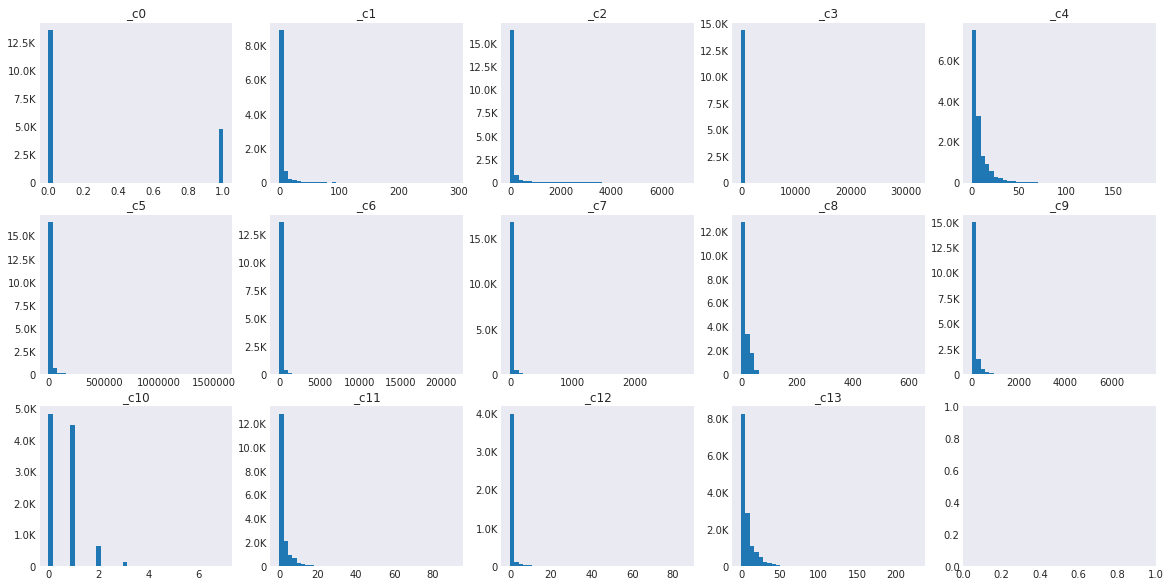

In [278]:
from pyspark_dist_explore import hist, distplot
fig, axes = plt.subplots(nrows = 3, ncols=5)
fig.set_size_inches(20,10)
for i, col in enumerate(numerical_col):
    hist(axes[i//5, i%5], traindf_num.select(col), bins = 40)
    axes[i//5, i%5].set_title(col)

In [122]:
from pyspark.mllib.stat import Statistics

#### Check top occuring values per Columns

In [285]:
for col in df.columns[1:]:
    traindf.groupBy(col).count().sort(desc("count")).show()

+----+-----+
| _c1|count|
+----+-----+
|null| 8270|
| 0.0| 4288|
| 1.0| 1805|
| 2.0|  967|
| 3.0|  631|
| 4.0|  423|
| 5.0|  321|
| 6.0|  243|
| 7.0|  218|
| 9.0|  144|
| 8.0|  140|
|10.0|  102|
|11.0|   85|
|12.0|   74|
|13.0|   68|
|15.0|   65|
|14.0|   49|
|16.0|   45|
|18.0|   36|
|19.0|   32|
+----+-----+
only showing top 20 rows

+----+-----+
| _c2|count|
+----+-----+
| 0.0| 3175|
| 1.0| 2832|
|-1.0| 1926|
| 2.0| 1105|
| 3.0|  534|
| 4.0|  412|
| 5.0|  351|
| 6.0|  284|
| 7.0|  247|
| 8.0|  202|
| 9.0|  202|
|10.0|  172|
|12.0|  166|
|11.0|  162|
|13.0|  144|
|16.0|  128|
|17.0|  126|
|15.0|  119|
|14.0|  116|
|18.0|  105|
+----+-----+
only showing top 20 rows

+----+-----+
| _c3|count|
+----+-----+
|null| 3993|
| 1.0| 2342|
| 2.0| 1564|
| 3.0| 1163|
| 4.0|  923|
| 5.0|  763|
| 6.0|  624|
| 7.0|  516|
| 8.0|  450|
| 9.0|  386|
|10.0|  342|
|11.0|  339|
|13.0|  289|
|12.0|  288|
|14.0|  231|
|15.0|  213|
|17.0|  185|
|16.0|  183|
|19.0|  150|
|18.0|  149|
+----+-----+
only showing

In [84]:
from pyspark.sql.functions import countDistinct,col
df_counts = df_0005.agg(*(countDistinct(col(c)).alias(c) for c in df_0005.columns)).show()
df_counts.show()

+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+
|Label| I0|  I1| I2| I3|  I4|  I5| I6| I7|  I8| I9|I10|I11|I12| C0| C1|   C2|  C3| C4| C5|  C6| C7| C8|  C9| C10|  C11| C12|C13| C14|  C15|C16| C17|C18|C19|  C20|C21|C22| C23|C24| C25|
+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+
|    2| 95|1349|358| 70|9769|1030|392| 63|1042|  8| 70| 47|109|261|450|12574|8307| 86|  9|4987|142|  3|5481|2874|11739|2306| 25|3117|10366|  9|1684|770|  3|11156|  9| 14|4732| 44|3621|
+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+

